# RF simulation with charge transport data

In this tutorial we will be exploring RF simulations while including the results obtained from the poisson-drift-diffusion solver.

<div style="text-align: center;">
  <img src="support/main.png" alt="Alt text" style="max-width: 80%; height: auto;">
</div>

To do so, we will use the `InP_EOPM` class created in the `Building a PhotonicdDevice` tutorial. We shall start by redefining our class:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imodulator
import shapely
import openbandparams as obp
from imodulator.ElectroOpticalModel import InGaAsPElectroOpticalModel
from imodulator.ChargeSimulator import ChargeSimulatorSolcore
from imodulator.RFSimulator import RFSimulatorFEMWELL

%matplotlib inline

def tand_fitted_bcb(x):
    """
    Fitted to results from https://link.springer.com/article/10.1007/s10762-009-9552-0
    
    x must be in GHz
    """
    out =  0.0093839 - 0.01790336 * np.exp(-0.04773444 * (x - -4.64170761))

    if isinstance(x, (list, np.ndarray)):
        x = np.asarray(x)
    
        out[np.where(out<0.001)] = 0.001
    else:
        if out < 0.001:
            out = 0.001
    return out

class InP_EOPM:
    def __init__(
            self,
            **kwargs
    ):
        
        self.e = 1.60e-19 # electron charge in C
        self.e0 = 8.85e-12 # vacuum permittivity in F/m
        
        self.w_sig_metal = 5 # Width of signal metal in um
        self.metal_sep = 10 # Separation between signal and ground metals in um
        self.h_metal = 4 # Height of metals in um
        self.w_gnd_metal = 10
        
        self.w_wg = 1
        self.h_n = 0.4
        self.h_wg1 = 0.5
        self.h_wg2 = 0.3
        self.h_p1 = 1
        self.h_p2 = 0.2

        self.h_box = 4

        self.w_window = 100
        self.h_bottom = 30
        self.h_top = 30

        for kwarg, value in kwargs.items():
            if hasattr(self, kwarg):
                setattr(self, kwarg, value)
    
    def _make_meshes(self):
        # optical mesh
        self.optical_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        # RF mesh
        self.rf_mesh_settings = {
            'substrate': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'sig_metal': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_left': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_right': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'bcb': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
        }

        # eo mesh
        self.eo_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        self.charge_mesh_settings = {
            'substrate': {'resolution': 0.5},
            'background': {'resolution': 0.5},
            'sig_metal': {'resolution': 0.01},
            'n_metal_left': {'resolution': 0.01},
            'n_metal_right': {'resolution': 0.01},
            'n': {'resolution': 0.003},
            'wg1': {'resolution': 0.002},
            'wg2': {'resolution': 0.002},
            'p1': {'resolution': 0.003},
            'p2': {'resolution': 0.003},
        }

    def _create_polygons(self):
        #We will now set the RF properties of the metals and the BCB
        freq = np.linspace(0.1,100, 100) #GHz. This will be the simulation frequency
            
        eps_rf_metal = 1 - 1j*6e7/(2*np.pi*freq*1e9 * self.e0)
        eps_rf_metal = np.asarray([freq, eps_rf_metal])
        
        bcb_eps_real = 2.65*np.ones(100)
        bcb_eps_imag = bcb_eps_real * tand_fitted_bcb(freq)

        bcb_eps = bcb_eps_real - 1j*bcb_eps_imag
        bcb_eps = np.asarray([freq, bcb_eps])
        
        #Now we create the PhotoPolygons
        self.substrate = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                -self.h_box
            ),
            rf_eps = 11.7,
            name = 'substrate',
            optical_material=3**2,
            eo_mesh_settings=self.eo_mesh_settings['substrate'],
            rf_mesh_settings=self.rf_mesh_settings['substrate'],
            optical_mesh_settings=self.optical_mesh_settings['substrate'],
        )

        self.background = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal + self.h_top
            ),
            rf_eps = 1,
            optical_material=1,
            eo_mesh_settings=self.eo_mesh_settings['background'],
            rf_mesh_settings=self.rf_mesh_settings['background'],
            optical_mesh_settings=self.optical_mesh_settings['background'],
            name = 'background'
        )

        self.box = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box,
                self.w_window/2,
                0
            ),
            rf_eps = 3.9 - 1j*3.9*0.001,
            optical_material=1.44**2,
            eo_mesh_settings=self.eo_mesh_settings['box'],
            rf_mesh_settings=self.rf_mesh_settings['box'],
            optical_mesh_settings=self.optical_mesh_settings['box'],
            name = 'box'
        )

        n_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.n = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                0,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n
            ),
            rf_eps = n_obp_material.dielectric(T=300),
            optical_material=n_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['n'],
            rf_mesh_settings=self.rf_mesh_settings['n'],
            optical_mesh_settings=self.optical_mesh_settings['n'],
            charge_mesh_settings=self.charge_mesh_settings['n'],
            name = 'n',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': n_obp_material,
                'sol_Nd': 1e18
            }
        )

        wg1_obp_material = obp.GaInPAs(T=300, As = 0.53, a = obp.InP.a())
        self.wg1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n,
                self.w_wg/2,
                self.h_n + self.h_wg1
            ),
            rf_eps = wg1_obp_material.dielectric(T=300),
            optical_material=wg1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg1'],
            rf_mesh_settings=self.rf_mesh_settings['wg1'],
            optical_mesh_settings=self.optical_mesh_settings['wg1'],
            charge_mesh_settings=self.charge_mesh_settings['wg1'],
            name = 'wg1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0.53,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg1_obp_material,
                'sol_Nd': 1e16
            }
        )

        wg2_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.wg2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2
            ),
            rf_eps = wg2_obp_material.dielectric(T=300),
            optical_material=wg2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg2'],
            rf_mesh_settings=self.rf_mesh_settings['wg2'],
            optical_mesh_settings=self.optical_mesh_settings['wg2'],
            charge_mesh_settings=self.charge_mesh_settings['wg2'],
            name = 'wg2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Nd': 1e16
            }
        )

        p1_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.p1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1
            ),
            rf_eps = p1_obp_material.dielectric(T=300),
            optical_material=p1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p1'],
            rf_mesh_settings=self.rf_mesh_settings['p1'],
            optical_mesh_settings=self.optical_mesh_settings['p1'],
            charge_mesh_settings=self.charge_mesh_settings['p1'],
            name = 'p1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Na': 1e17
            }
        )

        p2_obp_material = obp.GaInAs(T=300, a = obp.InP.a())
        self.p2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = p2_obp_material.dielectric(T=300),
            optical_material=p2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p2'],
            rf_mesh_settings=self.rf_mesh_settings['p2'],
            optical_mesh_settings=self.optical_mesh_settings['p2'],
            charge_mesh_settings=self.charge_mesh_settings['p2'],
            name = 'p2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': p2_obp_material,
                'sol_Na': 1e19
            }
        )

        self.bcb_far_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                0,
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_left'
        )

        self.bcb_far_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.metal_sep + self.w_gnd_metal + self.w_sig_metal/2,
                0,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_right'
        )

        self.bcb_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n,
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_left'
        )

        self.bcb_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.w_wg/2,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_right'
        )

        self.sig_metal = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2,
                self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['sig_metal'],
            rf_mesh_settings=self.rf_mesh_settings['sig_metal'],
            optical_mesh_settings=self.optical_mesh_settings['sig_metal'],
            name = 'sig_metal',
            calculate_current=True,
            d_buffer_current=min(self.w_sig_metal/20, self.h_metal/20, 0.05)
        )

        self.n_metal_left = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n,
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_left'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_left'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_left'],
            name = 'n_metal_left',
            calculate_current=False
        )

        self.n_metal_right = imodulator.MetalPolygon(
            shapely.box(
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_right'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_right'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_right'],
            name = 'n_metal_right',
            calculate_current=False
        )

    def _initialize_device(self):
        photo_polygons = [
            self.sig_metal,
            self.n_metal_left,
            self.n_metal_right,
            self.p2,
            self.p1,
            self.wg2,
            self.wg1,
            self.n,
            self.box,
            self.bcb_left,
            self.bcb_right,
            self.bcb_far_left,
            self.bcb_far_right,
            self.substrate,
            self.background
        ]
        
        #Just in case there are empty polygons
        idxs_to_remove = []
        for i, poly in enumerate(photo_polygons):
            if np.isclose(poly.polygon.bounds[1], poly.polygon.bounds[3]):
                idxs_to_remove.append(i)
        for i in idxs_to_remove[::-1]:
            del photo_polygons[i]
        self.device = imodulator.PhotonicDevice(
            photo_polygons
        )

Successfully imported lumapi


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


Successfully imported nextnanopy
Successfully configured nextnano++ settings


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\nextnanopy\defaults.py:202: UserWarning: Unsupported products in config file: ['nextnano.NEGF++'] will be ignored. To not see this message, please remove unsupported products from the config file: C:\Users\20230622\.nextnanopy-configNote: nextnano.NEGF++ was renamed to nextnano.NEGF, nextnano.NEGF was renamed to nextnano.NEGF_classic. Please check the documentation for more details.
  warnings.warn(


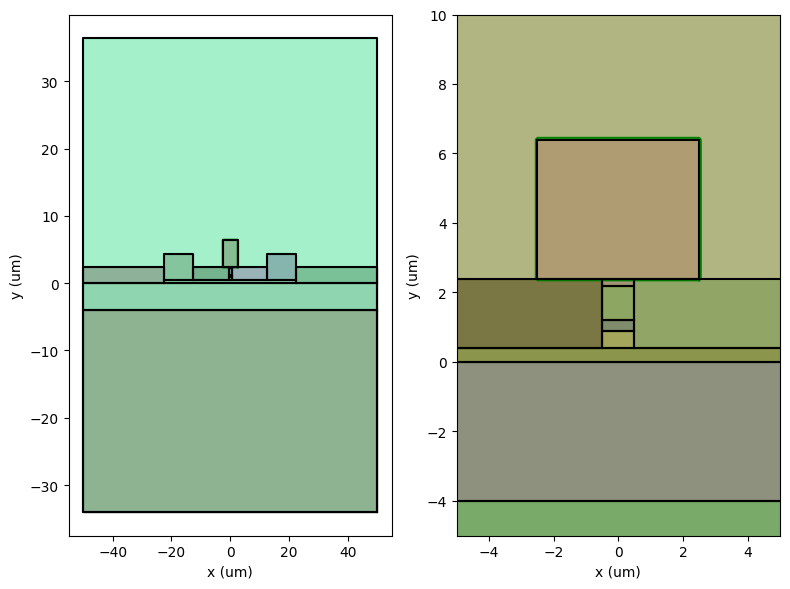

In [2]:
eopm = InP_EOPM()
eopm._make_meshes()
eopm._create_polygons()
eopm._initialize_device()

fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for ax in [ax1, ax2]:
    eopm.device.plot_polygons(
        color_polygon="black",
        color_line="green",
        color_junctions="blue",
        fill_polygons=True,
        fig=fig,
        ax=ax,
    )

ax2.set_xlim(-5,5)
ax2.set_ylim(-5,10)

ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
ax2.set_xlabel('x (um)')
ax2.set_ylabel('y (um)')

plt.tight_layout()
plt.show()

## Solving the poisson-drift-diffusion equation

Charge transport will take place with:
p2
p1
wg2
wg1
n


(-1.0, 3.0)

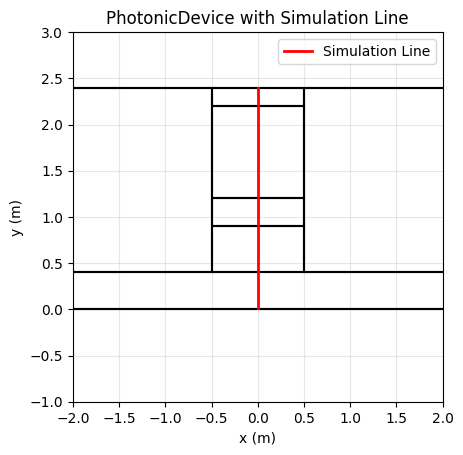

In [3]:
a=shapely.LineString([
	[0,0+0.01],
    [0,eopm.h_n+eopm.h_wg1+eopm.h_wg2+eopm.h_p1+eopm.h_p2 - 0.01]]) #simulation line

charge=ChargeSimulatorSolcore(
	device=eopm.device,
	simulation_line=a,
	bias_start_stop_step=[0,6,21]
)

fig, ax = charge.plot_with_simulation_line()

ax.set_xlim(-2,2)
ax.set_ylim(-1,3)

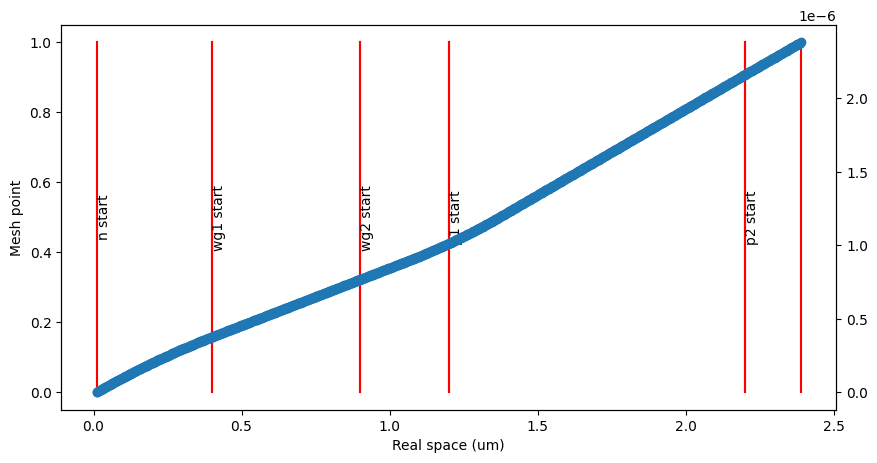

In [4]:
charge.plot_mesh()
plt.show()

Material "n" does not have k-data defined. Returning "zeros"
Material "wg1" does not have k-data defined. Returning "zeros"
Material "wg2" does not have k-data defined. Returning "zeros"
Material "p1" does not have k-data defined. Returning "zeros"
Material "p2" does not have k-data defined. Returning "zeros"
Solving IV of the junctions...


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\solcore\sesame_drift_diffusion\solve_pdd.py:193: UserWarning: All voltages are positive, but junction has been identified as n-p, so the  open-circuit voltage (Voc) of the junction will be negative.
  warnings.warn(


Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


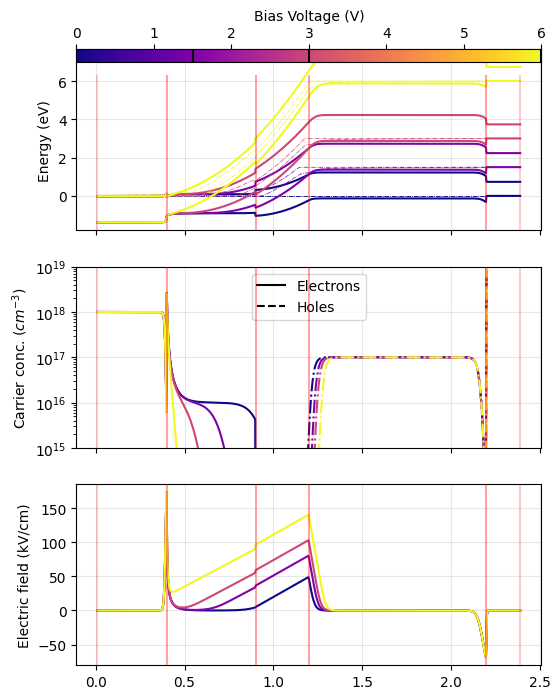

In [5]:
charge.solve_PDD(
	verbose = True*0,
	tol = 1e-6,
	max_iter = 1000,
	smooth_output=False,
)

charge.plot_results(
	V_idx = [0, 5, 10, 20],
	cmap = 'plasma'
	)

In [6]:
charge.transfer_results_to_device(xmin=-2, xmax=2, dx = 0.05)

## Solving the RF mode

Here we will move directly with a symmetry plane, as we will be characterizing a CPW line

Number of elements 638


(-5.0, 5.0)

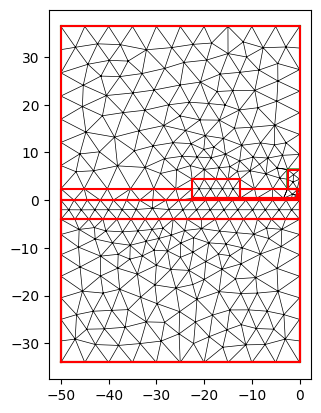

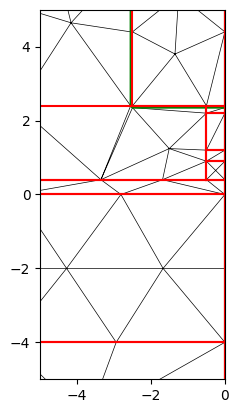

In [7]:
rf_sim = RFSimulatorFEMWELL(eopm.device, simulation_window=shapely.box(-300, -350, 0, 350))
rf_sim.make_mesh(
	gmsh_algorithm=1
)

print('Number of elements', rf_sim.mesh.nelements)
fig, ax = rf_sim.plot_mesh()

fig2, ax2 = rf_sim.plot_mesh()

ax2.set_xlim(-5,0)
ax2.set_ylim(-5,5)

We can now inspect the permitivity of our structure, but as opposed to what was done in the `RF Simulation` tutorial, we now have charge data with some voltage dependency. Therefore, we can use the keyword arguments `use_charge_transport_data` and `voltage_idx`. When using the charge transport data, we simply use them to calculate the conductivity assuming the Drude model:

$$
\sigma (x,y,V) = e\left(\mu_n (x,y) N(x,y,V) + \mu_p (x,y) P(x,y,V)\right)
$$

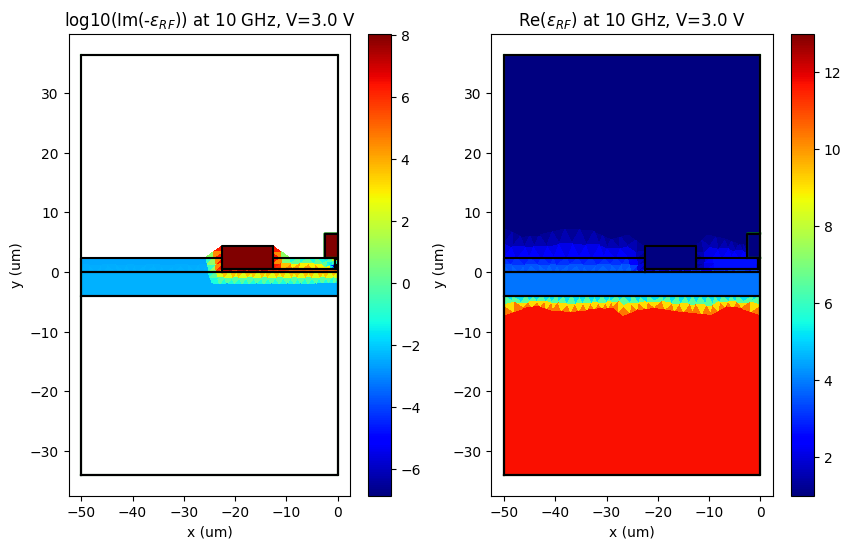

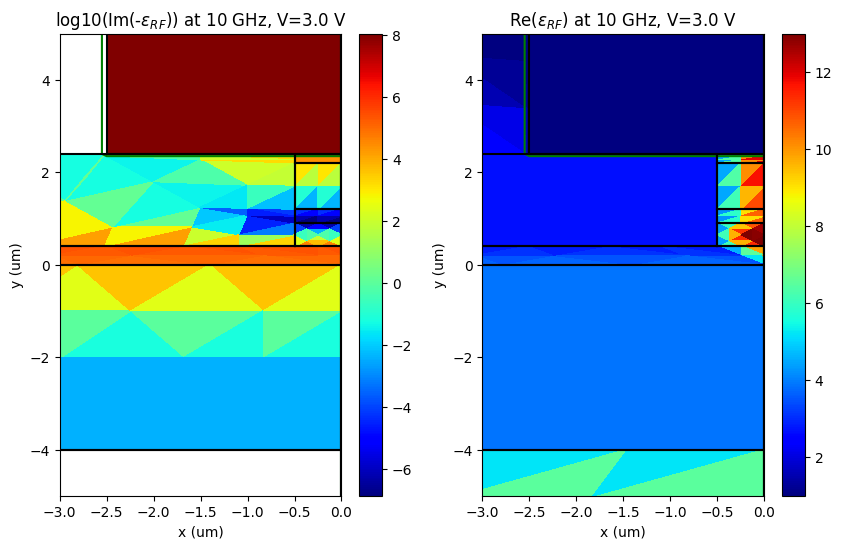

In [12]:
_ = rf_sim.plot_eps_rf(
    frequency=10, #GHz
    log_scale_re=False,
    log_scale_im=True,
    use_charge_transport_data=True,
    voltage_idx=10
)

fig, ax1, ax2 = rf_sim.plot_eps_rf(
    frequency=10, #GHz
    log_scale_re=False,
    log_scale_im=True,
    use_charge_transport_data=True,
    voltage_idx=10
)

for ax in [ax1, ax2]:
    ax.set_xlim(-3,0)
    ax.set_ylim(-5,5)

For the moment the mesh is quite coarse and we cannot see much. Let us calculate some modes and then move to some mesh refinement

Effective index - mode 0: 0.3749
loss - mode 0: -2697.08 dB/cm
#------------------------------------------#
Effective index - mode 1: 2.1328
loss - mode 1: 0.67 dB/cm
#------------------------------------------#
Effective index - mode 2: 4.1897
loss - mode 2: 4.94 dB/cm
#------------------------------------------#


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


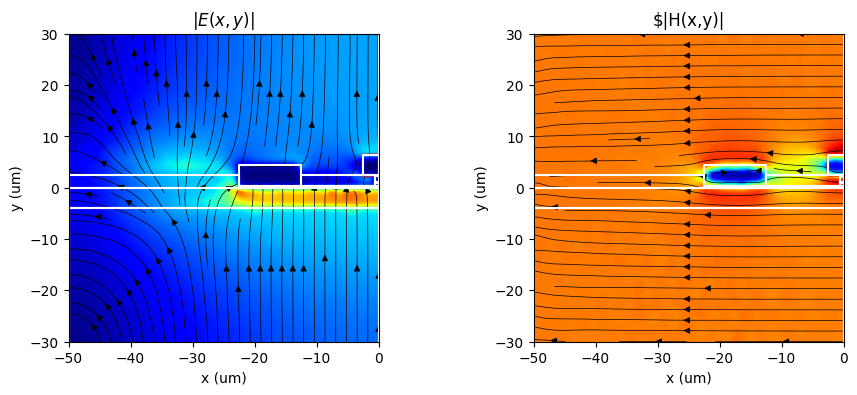

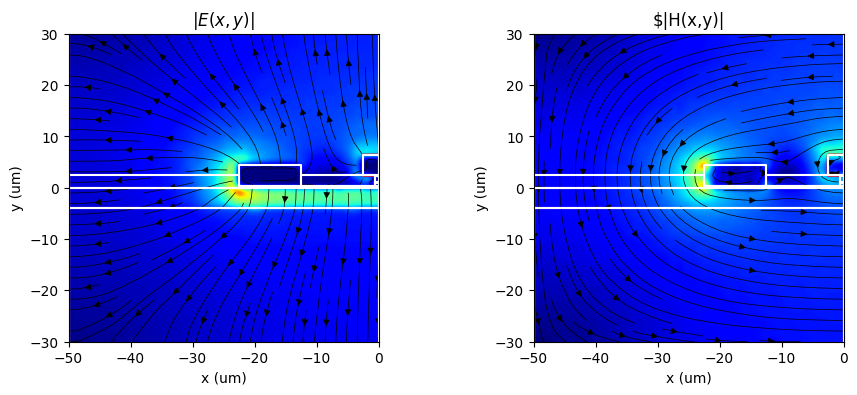

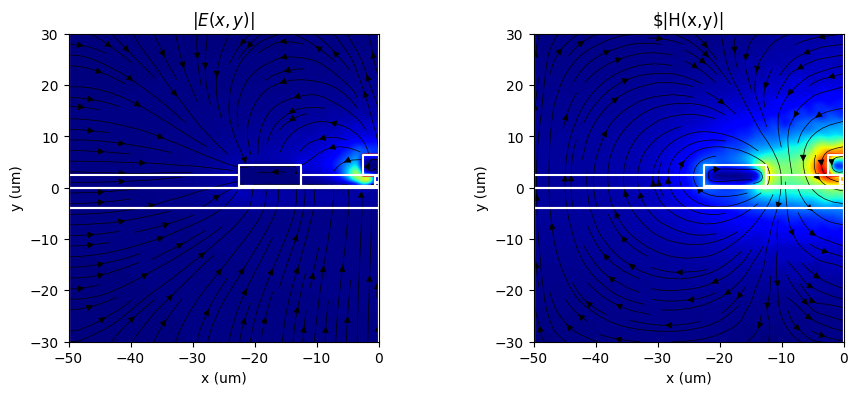

In [18]:
rf_sim.compute_modes(
            frequency = 12,
            metallic_boundaries = ['left', 'bottom','top'],
            n_guess = 2,
            num_modes = 3,
            order = 1,
            return_modes = True,
            use_charge_transport_data=True,
            voltage_idx=10
)

for i in range(len(rf_sim.modes)):
    print(f'Effective index - mode {i}: {rf_sim.modes[i].n_eff.real:.4f}')
    print(f'loss - mode {i}: {rf_sim.modes[i].calculate_propagation_loss(1e4):.2f} dB/cm')
    print('#------------------------------------------#')

for mode_idx in range(len(rf_sim.modes)):
	rf_sim.plot_mode(
        rf_sim.modes[mode_idx],
        Nx=50,
        Ny=50,
        xmin = -50,
        xmax=0,
        ymin=-30,
        ymax=30
    )

With this we see we are interested in mode number 1. Let us hope there is no mode jump and we can stay with mode index 2 for the full refinement.

In [19]:
errors = []
neff = []
loss = []
nelements = []
z0 = []

rf_sim.make_mesh()
for i in range(30):
    print(f'--- Refinement iteration {i} ---')
    
    rf_sim.compute_modes(
            frequency = 12,
            metallic_boundaries = ['left', 'bottom','top'],
            n_guess = 2,
            num_modes = 3,
            order = 1,
            return_modes = True,
            use_charge_transport_data=True,
            voltage_idx=10
    )


    loss_tmp = []
    for mode in rf_sim.modes:
        loss_tmp.append(mode.calculate_propagation_loss(1e4))

    idx_mode = 2
    

    ######### Calculate characteristic impedance #########
    p0, i0_all, _ = rf_sim.get_currents(mode = rf_sim.modes[idx_mode])

    I0 = 2*i0_all['sig_metal']
    p0 = 2*p0 

    Z0 = p0/np.abs(I0)**2
    z0.append(Z0)
    ######################################################

    nelements.append(rf_sim.mesh.nelements)
    neff.append(rf_sim.modes[idx_mode].n_eff.real)
    loss.append(rf_sim.modes[idx_mode].calculate_propagation_loss(1e4))

    rf_sim.refine_mesh(mode_for_refinement=rf_sim.modes[idx_mode])

    print(f'Nelements: {rf_sim.mesh.nelements} | neff: {neff[-1]:.6f} | loss: {loss[-1]:.2f} dB/cm | Z0: {z0[-1]:.2f} Ohm')


# plt.show()

--- Refinement iteration 0 ---
Nelements: 940 | neff: 4.348577 | loss: 8.80 dB/cm | Z0: 76.85-4.60j Ohm
--- Refinement iteration 1 ---
Nelements: 1033 | neff: 4.226509 | loss: 8.48 dB/cm | Z0: 78.50-4.89j Ohm
--- Refinement iteration 2 ---
Nelements: 1103 | neff: 3.686867 | loss: 8.66 dB/cm | Z0: 91.91-4.51j Ohm
--- Refinement iteration 3 ---
Nelements: 1131 | neff: 3.603673 | loss: 8.48 dB/cm | Z0: 93.40-4.72j Ohm
--- Refinement iteration 4 ---
Nelements: 1247 | neff: 3.544029 | loss: 8.27 dB/cm | Z0: 92.92-4.84j Ohm
--- Refinement iteration 5 ---
Nelements: 1402 | neff: 3.449524 | loss: 7.96 dB/cm | Z0: 87.81-4.76j Ohm
--- Refinement iteration 6 ---
Nelements: 1467 | neff: 3.436453 | loss: 7.71 dB/cm | Z0: 76.53-3.99j Ohm
--- Refinement iteration 7 ---
Nelements: 1671 | neff: 3.437134 | loss: 7.73 dB/cm | Z0: 67.80-3.60j Ohm
--- Refinement iteration 8 ---
Nelements: 1709 | neff: 3.398102 | loss: 7.56 dB/cm | Z0: 63.12-3.27j Ohm
--- Refinement iteration 9 ---
Nelements: 2150 | neff: 3

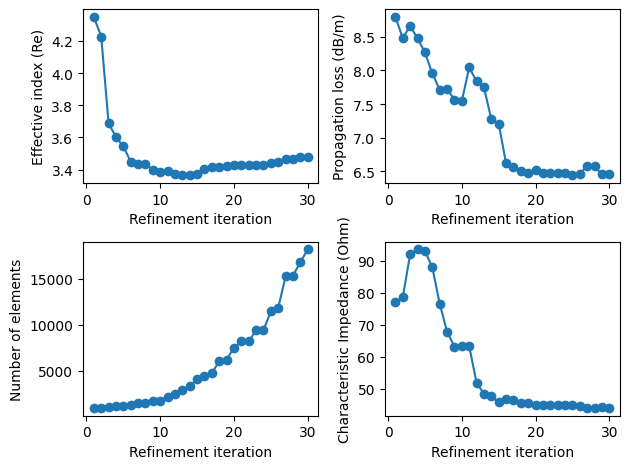

In [20]:
fig = plt.figure()
gs = fig.add_gridspec(2, 2)

n_iterations = np.arange(len(nelements))+1

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.plot(n_iterations, neff, marker='o')
ax2.plot(n_iterations, loss, marker='o')
ax3.plot(n_iterations, nelements, marker='o')
ax4.plot(n_iterations, np.abs(z0), marker='o')

ax1.set_xlabel('Refinement iteration')
ax2.set_xlabel('Refinement iteration')
ax3.set_xlabel('Refinement iteration')
ax4.set_xlabel('Refinement iteration')

ax1.set_ylabel('Effective index (Re)')
ax2.set_ylabel('Propagation loss (dB/m)')
ax3.set_ylabel('Number of elements')
ax4.set_ylabel('Characteristic Impedance (Ohm)')

plt.tight_layout()
plt.show()

(-10.0, 10.0)

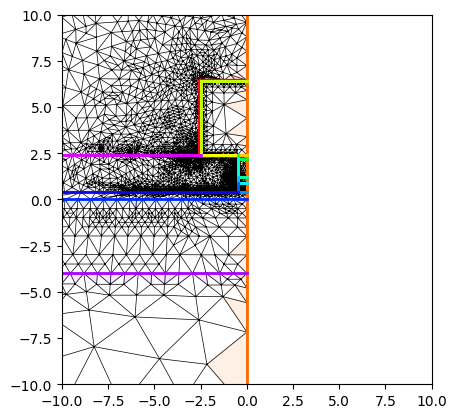

In [25]:
ax = rf_sim.mesh.draw(boundaries=True)

ax.set_axis_on()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

C:\Users\20230622\OneDrive - TU Eindhoven\PhD\Python packages\photonmod\src\imodulator\RFSimulator.py:506: RuntimeWarning: divide by zero encountered in log10
  data_to_plot_im = np.log10(-data_to_plot_im)
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\skfem\assembly\basis\cell_basis.py:152: RuntimeWarning: invalid value encountered in multiply
  w += y[self.element_dofs[j]][:, None] * basis[0]


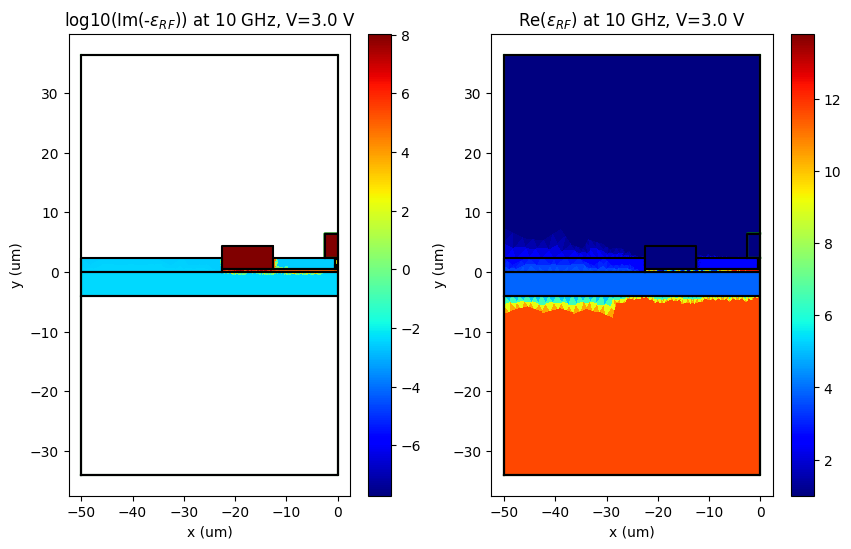

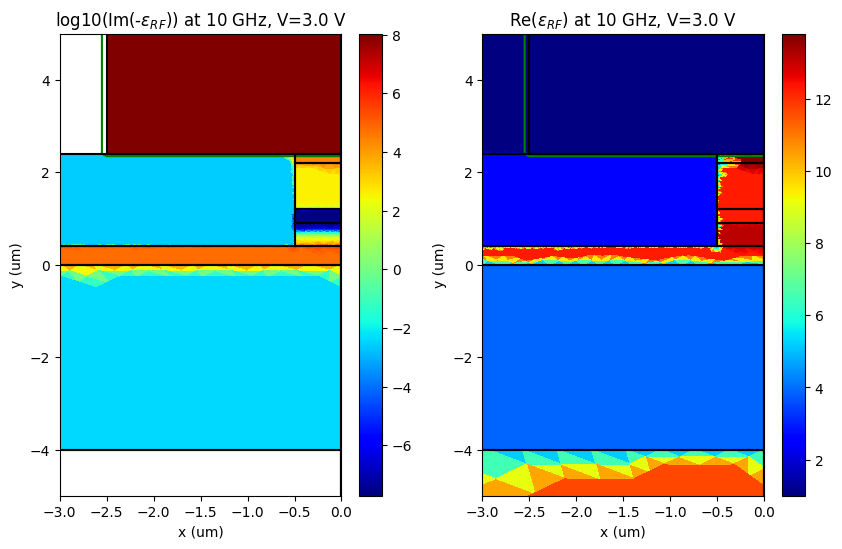

In [26]:
_ = rf_sim.plot_eps_rf(
    frequency=10, #GHz
    log_scale_re=False,
    log_scale_im=True,
    use_charge_transport_data=True,
    voltage_idx=10
)

fig, ax1, ax2 = rf_sim.plot_eps_rf(
    frequency=10, #GHz
    log_scale_re=False,
    log_scale_im=True,
    use_charge_transport_data=True,
    voltage_idx=10
)

for ax in [ax1, ax2]:
    ax.set_xlim(-3,0)
    ax.set_ylim(-5,5)

As you can see we now see far more details than before, where even the depletion region is now well defined.

## Frequency sweep

In [27]:
freq_values = np.linspace(1,100,30)

n_modes = 2
neff_values = np.zeros((n_modes, freq_values.shape[0]))
loss_values = np.zeros((n_modes, freq_values.shape[0]))
Z0_values = np.zeros((n_modes, freq_values.shape[0]), dtype=complex)
s11_values = np.zeros((n_modes, freq_values.shape[0]), dtype=complex)
s12_values = np.zeros((n_modes, freq_values.shape[0]), dtype=complex)

for i, f in enumerate(freq_values):
    print(f'--- Frequency: {f} GHz ---')
    rf_sim.compute_modes(
        frequency = f,
        metallic_boundaries = ['left', 'bottom', 'top'],
        voltage_idx = 10,
        n_guess = 2,
        num_modes = n_modes,
        order = 1,
        return_modes = False,
        use_charge_transport_data=True
    )

    #Let us select the mode that has a positive value for loss
    #The current geometry will only allow for one physical mode. We are purposely calculating two modes, but one of them will be some radiative mode with negative loss (gain).
    for j in range(n_modes):
        loss = rf_sim.modes[j].calculate_propagation_loss(1e4) #dB/cm
        p0, i0_all, _ = rf_sim.get_currents(mode = rf_sim.modes[j])

        p0 = 2*p0 
        I0 = 2*i0_all['sig_metal']

        Z0 = p0/np.abs(I0)**2

        s11, s12 = rf_sim.get_S(
            rf_sim.modes[j].k,
            Z = Z0 ,
            ZL=50,
            ZS = 50,
            L = 1e3 #um
        )
        

        neff_values[j, i] = rf_sim.modes[j].n_eff.real
        loss_values[j, i] = rf_sim.modes[j].calculate_propagation_loss(1e4) #dB/cm
        Z0_values[j, i] = Z0
        s11_values[j, i] = s11
        s12_values[j, i] = s12

--- Frequency: 1.0 GHz ---
--- Frequency: 4.413793103448276 GHz ---
--- Frequency: 7.827586206896552 GHz ---
--- Frequency: 11.241379310344827 GHz ---
--- Frequency: 14.655172413793103 GHz ---
--- Frequency: 18.06896551724138 GHz ---
--- Frequency: 21.482758620689655 GHz ---
--- Frequency: 24.89655172413793 GHz ---
--- Frequency: 28.310344827586206 GHz ---
--- Frequency: 31.724137931034484 GHz ---
--- Frequency: 35.13793103448276 GHz ---
--- Frequency: 38.55172413793103 GHz ---
--- Frequency: 41.96551724137931 GHz ---
--- Frequency: 45.37931034482759 GHz ---
--- Frequency: 48.79310344827586 GHz ---
--- Frequency: 52.206896551724135 GHz ---
--- Frequency: 55.62068965517241 GHz ---
--- Frequency: 59.03448275862069 GHz ---
--- Frequency: 62.44827586206897 GHz ---
--- Frequency: 65.86206896551724 GHz ---
--- Frequency: 69.27586206896552 GHz ---
--- Frequency: 72.6896551724138 GHz ---
--- Frequency: 76.10344827586206 GHz ---
--- Frequency: 79.51724137931035 GHz ---
--- Frequency: 82.9310344

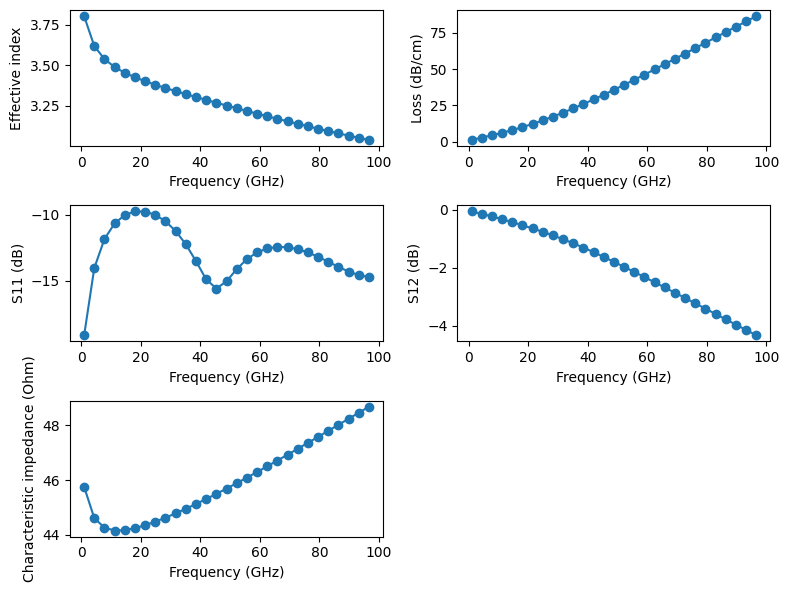

In [31]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(3, 2)

ax_neff = fig.add_subplot(gs[0, 0])
ax_loss = fig.add_subplot(gs[0, 1])
ax_Z0 = fig.add_subplot(gs[2, 0])
ax_s11 = fig.add_subplot(gs[1, 0])
ax_s12 = fig.add_subplot(gs[1, 1])

a = -1
for i in [1]:
    ax_neff.plot(freq_values[:a], neff_values[i, :a], label=f'Mode {i}', marker='o')

    ax_loss.plot(freq_values[:a], loss_values[i, :a], label=f'Mode {i}', marker='o')

    # ax_Z0.plot(freq_values[:a], Z0_values[i, :a].real, label=f'Mode {i} (Re)', marker='o')
    # ax_Z0.plot(freq_values[:a], Z0_values[i, :a].imag, label=f'Mode {i} (Im)', marker='o')
    ax_Z0.plot(freq_values[:a], np.abs(Z0_values[i, :a]), label=f'Mode {i} (Abs)', marker='o')

    ax_s11.plot(freq_values[:a], 10 * np.log10(np.abs(s11_values[i, :a])), label=f'Mode {i} (Re)', marker='o')

    ax_s12.plot(freq_values[:a], 10 * np.log10(np.abs(s12_values[i, :a])), label=f'Mode {i} (Re)', marker='o')

# ax_neff.set_ylim(2,5)
ax_neff.set_xlabel('Frequency (GHz)')
ax_neff.set_ylabel('Effective index')

ax_loss.set_xlabel('Frequency (GHz)')
ax_loss.set_ylabel('Loss (dB/cm)')

ax_Z0.set_xlabel('Frequency (GHz)')
ax_Z0.set_ylabel('Characteristic impedance (Ohm)')

ax_s11.set_xlabel('Frequency (GHz)')
ax_s11.set_ylabel('S11 (dB)')

ax_s12.set_xlabel('Frequency (GHz)')
ax_s12.set_ylabel('S12 (dB)')

fig.tight_layout()

plt.show()

## Voltage sweep

Since we now have voltage data information, it becomes simple to study how the small signal characteristics are expected to vary with voltage. This will innevitably be a measure of how linear the electrical propagation will be.

In [33]:
V_values = np.asarray(list(eopm.device.charge['V']))

n_modes = 2
neff_values = np.zeros((n_modes, V_values.shape[0]))
loss_values = np.zeros((n_modes, V_values.shape[0]))
Z0_values = np.zeros((n_modes, V_values.shape[0]), dtype=complex)
s11_values = np.zeros((n_modes, V_values.shape[0]), dtype=complex)
s12_values = np.zeros((n_modes, V_values.shape[0]), dtype=complex)


for i, f in enumerate(V_values):
    print(f'--- Voltage: {f} V ---')
    rf_sim.compute_modes(
        frequency = 20,
        metallic_boundaries = ['left', 'bottom', 'top'],
        voltage_idx = i,
        n_guess = 3,
        num_modes = n_modes,
        order = 1,
        return_modes = True,
        use_charge_transport_data=True
    )


    #Let us select the mode that has a positive value for loss
    #The current geometry will only allow for one physical mode. We are purposely calculating two modes, but one of them will be some radiative mode with negative loss (gain).
    for j in range(n_modes):
        loss = rf_sim.modes[j].calculate_propagation_loss(1e4) #dB/cm
        p0, i0_all, _ = rf_sim.get_currents(mode = rf_sim.modes[j])

        p0 = 2*p0 #This correction is needed as the power of the actual field we are interested in is twice of the one calculated by the simulator
        I0 = 2*i0_all['sig_metal']
        
        Z0 = p0/np.abs(I0)**2

        s11, s12 = rf_sim.get_S(
            rf_sim.modes[j].k ,
            Z = Z0 ,
            ZL=50,
            ZS = 50,
            L = 1e3 #um
        )
        

        neff_values[j, i] = rf_sim.modes[j].n_eff.real
        loss_values[j, i] = rf_sim.modes[j].calculate_propagation_loss(1e4) #dB/cm
        Z0_values[j, i] = Z0
        s11_values[j, i] = s11
        s12_values[j, i] = s12

--- Voltage: 0.0 V ---
--- Voltage: 0.3 V ---
--- Voltage: 0.6 V ---
--- Voltage: 0.8999999999999999 V ---
--- Voltage: 1.2 V ---
--- Voltage: 1.5 V ---
--- Voltage: 1.7999999999999998 V ---
--- Voltage: 2.1 V ---
--- Voltage: 2.4 V ---
--- Voltage: 2.6999999999999997 V ---
--- Voltage: 3.0 V ---
--- Voltage: 3.3 V ---
--- Voltage: 3.5999999999999996 V ---
--- Voltage: 3.9 V ---
--- Voltage: 4.2 V ---
--- Voltage: 4.5 V ---
--- Voltage: 4.8 V ---
--- Voltage: 5.1 V ---
--- Voltage: 5.3999999999999995 V ---
--- Voltage: 5.7 V ---
--- Voltage: 6.0 V ---


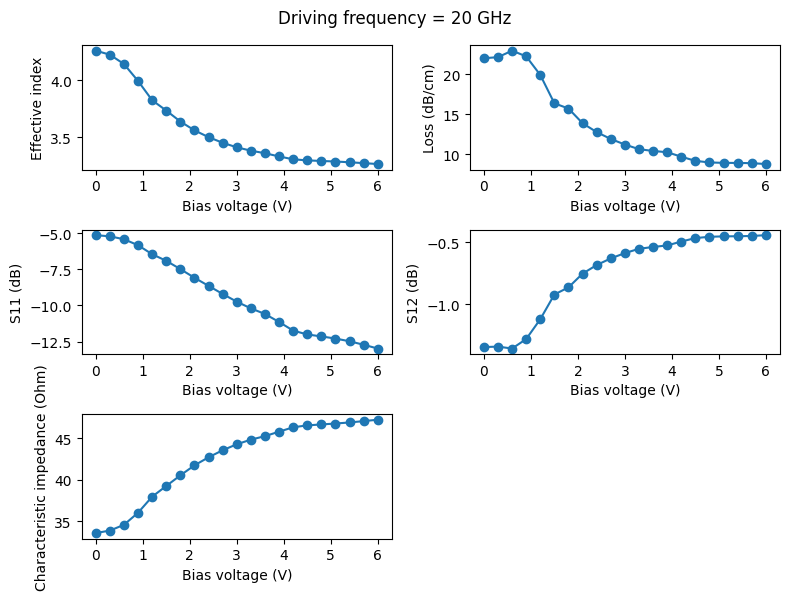

In [36]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(3, 2)

ax_neff = fig.add_subplot(gs[0, 0])
ax_loss = fig.add_subplot(gs[0, 1])
ax_Z0 = fig.add_subplot(gs[2, 0])
ax_s11 = fig.add_subplot(gs[1, 0])
ax_s12 = fig.add_subplot(gs[1, 1])

for i in [1]:
    ax_neff.plot(V_values, neff_values[i], label=f'Mode {i}', marker='o')

    ax_loss.plot(V_values, loss_values[i], label=f'Mode {i}', marker='o')

    ax_Z0.plot(V_values, np.abs(Z0_values[i]), label=f'Mode {i} (Abs)', marker='o')

    ax_s11.plot(V_values, 10 * np.log10(np.abs(s11_values[i])), label=f'Mode {i} (Re)', marker='o')

    ax_s12.plot(V_values, 10 * np.log10(np.abs(s12_values[i])), label=f'Mode {i} (Re)', marker='o')

# ax_neff.set_ylim(2.5,4)
ax_neff.set_xlabel('Bias voltage (V)')
ax_neff.set_ylabel('Effective index')

ax_loss.set_xlabel('Bias voltage (V)')
ax_loss.set_ylabel('Loss (dB/cm)')

ax_Z0.set_xlabel('Bias voltage (V)')
ax_Z0.set_ylabel('Characteristic impedance (Ohm)')

ax_s11.set_xlabel('Bias voltage (V)')
ax_s11.set_ylabel('S11 (dB)')

ax_s12.set_xlabel('Bias voltage (V)')
ax_s12.set_ylabel('S12 (dB)')

fig.suptitle('Driving frequency = 20 GHz')
fig.tight_layout()

We can clearly see an improvement on the performance due to the increase of the depletion region size with increasing reverse bias voltage.